# MCMC testing notebook: Bilby MCMC

This notebook tests the implmentation of Bilby using the finite-difference model. Thinning is set such that the inference samples are all independent (slow). Bilby runs multiple chains but appears to combine them at the end into a single chain. Also, the sampler ends with the total number of samples from all chains equals the total, not each chain independently.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import bilby as bb
import arviz as az

from advdiff_mcmc.advdiff.fd_utils import generate_grid, calc_Ks
from advdiff_mcmc.advdiff.fdm_implement import obj_CN

sns.set()
sns.set_style("white")
sns.set_style("ticks")


## Create the synthetic forcing data

In [3]:
del_z = 1.0
h_tot = 16.0

del_t = 300.0
T_tot = 12*60*60

bbl_h = 15

km_bg = 10**-4

fg, mg, tg = generate_grid(h_tot, del_z, T_tot, del_t) 
print('Grid size = ', str(len(mg)), ' x ', str(len(tg)))

Grid size =  16  x  145


In [4]:
# Specify a u* time series for diffusivity profile
f_wave = 0.17*np.sin(np.linspace(-np.pi/2,3.5*np.pi,len(tg))) + 0.20

u_bed = np.sqrt((f_wave)**2 * 0.00185)
t_bed = 1035*u_bed**2

# Calculate diffusivity profile
Ks_all = calc_Ks(u_bed, fg, np.repeat(bbl_h, len(tg)), km_bg)

## Create the synthetic SSC data

#### Pick some realistic parameters from literature

In [5]:
w_s = 1.0 # [x10-3 m/s]
t_c = 7.0 # [x10-2 Pa]
e_0 = 3.0 # [x10-4 g/m2/s]
m_c = None
b_c = 1.1 # close to one makes the model difficult to sample

theta_syn = [w_s, e_0, t_c, m_c, b_c, 0]

In [6]:
# Run the model once to get initial profile
model_spec = [tg, mg, fg, np.zeros_like(mg), Ks_all, h_tot, t_bed]

syn_init = obj_CN(theta_syn, 'E1', model_spec)
cn_rn = syn_init[-1,:]

# Run the model again to get the final synthetic data
model_spec = [tg, mg, fg, cn_rn, Ks_all, h_tot, t_bed]
syn_final = obj_CN(theta_syn, 'E1', model_spec)

obs_htx = ((mg >= 0.4) & (mg <= 0.6)) | ((mg >= 8.4) & (mg <= 8.6))

## Add noise to the synthetic SSC


In [7]:
obs_mod = np.copy(syn_final)

noise_sd = 2/1000
noise_meas = np.random.normal(0, noise_sd, np.shape(obs_mod))
obs_meas = obs_mod + noise_meas

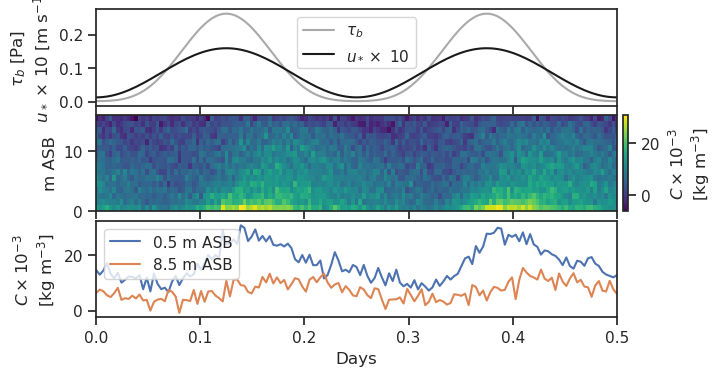

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(8,4))
plt.subplots_adjust(hspace=0.1)

ax[0].plot(tg/60/60/24, t_bed, label='$\\tau_b$', c='darkgrey')
ax[0].plot(tg/60/60/24, 10*u_bed, label=r'$u_* \times$ 10', c='k')

ax[0].set_ylabel('$\\tau_b$ [Pa]\n $u_*$ $\\times$ 10 [m s$^{-1}$]')
ax[0].legend()

pc=ax[1].pcolormesh(tg/60/60/24, mg, 1000*obs_meas.T, cmap=cm.viridis)
cb2 = fig.colorbar(pc, ax=ax[1], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$C \\times 10^{-3}$\n[kg m$^{-3}$]')

ax[1].set_ylabel('m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][0]*1000, label=str(mg[obs_htx][0]) + ' m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][-1]*1000, label=str(mg[obs_htx][-1]) + ' m ASB')
ax[2].legend()

ax[2].set_ylabel('$C \\times 10^{-3}$\n[kg m$^{-3}$]')
ax[2].set_xlabel('Days')

ax_zero = ax[1].get_position().bounds
for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')

    if x != ax[1]:
        ax_one = x.get_position().bounds
        x.set_position([ax_zero[0], ax_one[1], ax_zero[2], ax_one[3]])

# Test the inference method: Bilby-MCMC

In [9]:
# Create wrap for bilby model
def bb_model(tg, w_s_inp, e_0_inp, t_c_inp, b_c_inp, sigma):
    theta = [w_s_inp, e_0_inp, t_c_inp, 0.0, b_c_inp, sigma]
    return 1000*obj_CN(theta, 'E1', model_spec)[:,obs_htx]

In [10]:
label = "Bilby_testing_V2"
outdir = label
bb.utils.check_directory_exists_and_if_not_mkdir(outdir)

likelihood = bb.core.likelihood.GaussianLikelihood(tg,\
                                                   1000*obs_meas[:,obs_htx],\
                                                   bb_model)

priors = {}
priors["w_s_inp"] = bb.core.prior.LogNormal(0.5, 0.7, name="w_s_inp", latex_label="w_s_inp")
priors["e_0_inp"] = bb.core.prior.HalfNormal(2, name="e_0_inp")
priors["t_c_inp"] = bb.core.prior.HalfNormal(3, name="t_c_inp")
# priors["m_c_inp"] = bb.core.prior.HalfNormal(3, name="m_c_inp")
priors["b_c_inp"] = bb.core.prior.LogNormal(0.25, 0.5, name="b_c_inp")
priors["sigma"] = bb.core.prior.HalfNormal(3, name="sigma")

In [11]:
priors_dict = bb.prior.dict.PriorDict(priors)

In [12]:
from bilby.bilby_mcmc.proposals import ProposalCycle, AdaptiveGaussianProposal, DifferentialEvolutionProposal
proposal_cycle_list = []
# proposal_cycle_list.append(AdaptiveGaussianProposal(priors_dict, weight=1))
proposal_cycle_list.append(DifferentialEvolutionProposal(priors_dict, weight=1))
proposal_cycle = ProposalCycle(proposal_cycle_list)

The run crashed closed to finishing 500 samples, so I have just run it for 1 more sample (Bilby loads its recent checkpoint, if available).

In [13]:
result_samp = bb.run_sampler(
                        likelihood,
                        priors,
                        sampler="bilby_mcmc",
                        nsamples=1, #500 # This is the number of samples
                        thin_by_nact=1.0,  # This sets the thinning factor
                        nensemble=4,   # This appears to set the number of chains in the results
                        pt_ensemble=True,
                        ntemps=3,  # The number of parallel-tempered chains
                        npool=4,  # The multiprocessing cores to use
                        L1steps=1,  # The number of internal steps to take for each iteration
                        proposal_cycle=proposal_cycle,  # noAG_noDE_noFG_noNF 'default_noUN_noKD_noFM_noGM'
                        printdt=300,  # Print a progress update every n seconds
                        check_point_delta_t=300,  # Checkpoint and create progress plots every n seconds
                        outdir=outdir,
                        label=label,
                        verbose=False)

10:53 bilby INFO    : Running for label 'Bilby_testing_V2', output will be saved to 'Bilby_testing_V2'
10:53 bilby INFO    : Analysis priors:
10:53 bilby INFO    : w_s_inp=LogNormal(mu=0.5, sigma=0.7, name='w_s_inp', latex_label='w_s_inp', unit=None, boundary=None)
10:53 bilby INFO    : e_0_inp=HalfNormal(sigma=2, name='e_0_inp', latex_label='e_0_inp', unit=None, boundary=None)
10:53 bilby INFO    : t_c_inp=HalfNormal(sigma=3, name='t_c_inp', latex_label='t_c_inp', unit=None, boundary=None)
10:53 bilby INFO    : b_c_inp=LogNormal(mu=0.25, sigma=0.5, name='b_c_inp', latex_label='b_c_inp', unit=None, boundary=None)
10:53 bilby INFO    : sigma=HalfNormal(sigma=3, name='sigma', latex_label='sigma', unit=None, boundary=None)
10:53 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
10:53 bilby INFO    : Analysis likelihood noise evidence: nan
10:53 bilby INFO    : Single likelihood evaluation took 5.549e-02 s
10:53 bilby INFO    : Using sampler Bilb

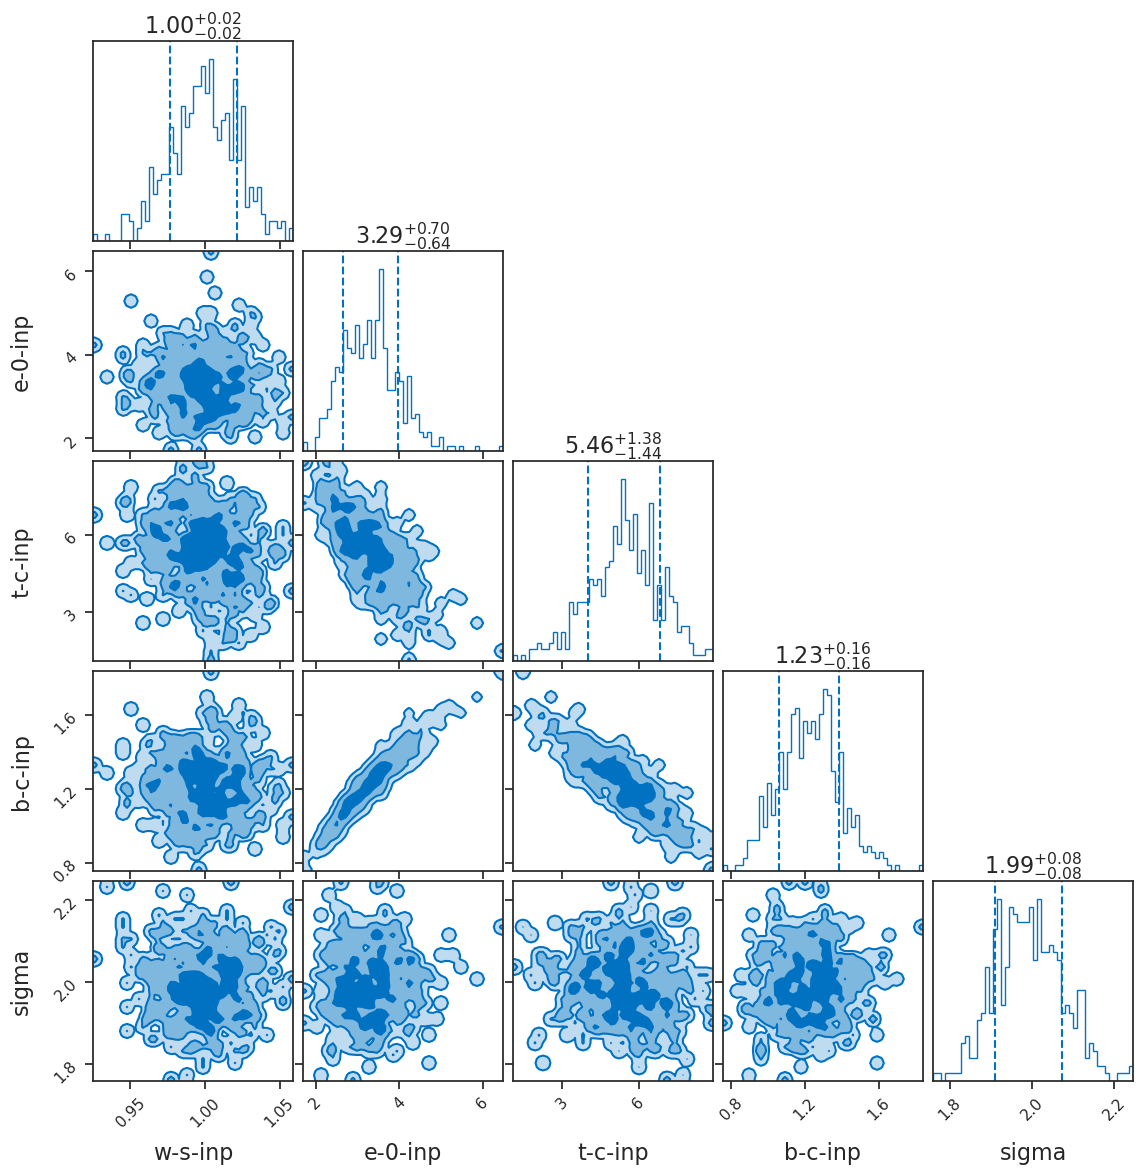

In [14]:
result_samp.plot_corner()

In [15]:
inf_obj = result_samp.to_arviz()

In [16]:
inf_obj

Inference data with groups:
	> posterior
	> log_likelihood

/home/wedge/anaconda3/envs/py10/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


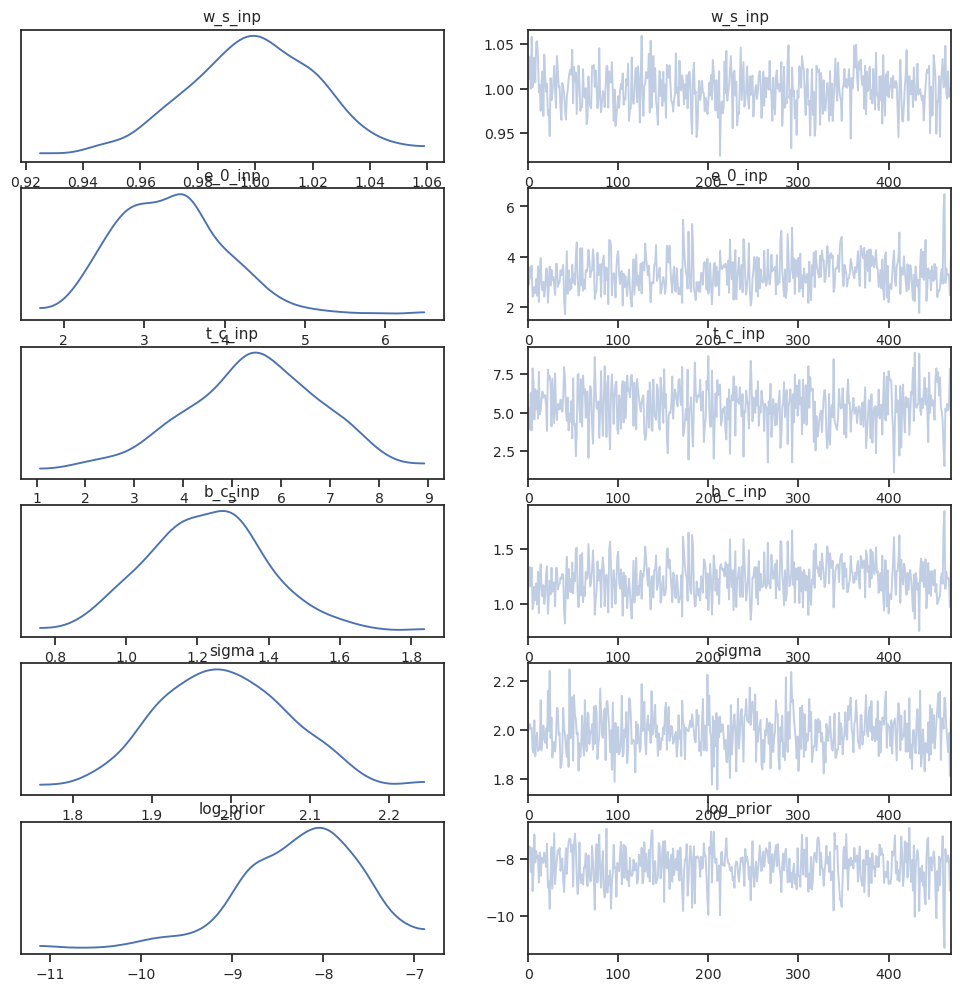

In [17]:
_=az.plot_trace(inf_obj, compact=False)

Note the above traceplot is n chains stiched together for Bilby.